<a href="https://colab.research.google.com/github/tnguyen7s/CNN-trash-classifier/blob/master/mnist_fc_complete/mnist_fc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
from google.colab import drive

# Set up Device for training

In [2]:
GPU = torch.cuda.is_available()

if GPU:
  device = torch.device('cuda')
  print('Using GPU')
else:
  device = torch.device('cpu')
  print('Using CPU')

Using GPU


# Data

As we loop through  each batch in the loader, we want apply these transformations to the batch. 

Here for each batch of images:
1. Resize to 20x20 image
2. Convert the image to gray scale
3. Convert the image to a 2d array
4. Normalize the image by specifying mean and standard deviation for each color channel. Since our image is in grayscale, we only need to specify the mean the one channel inside a tuple.

In [3]:
transformer = transforms.Compose([
    transforms.Resize((20,20)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,), std=(1,))
])

We can also apply data augmentation (such as random crop, random rotate, translate, contrast, ect.) to our dataset. This helps:
* Increase the number of training images. 
* Make the model robust in prediction, for instance the model should correctly predict an image even if the digit is located somewhere, not neccessary to be at the center of the image.
* Thus, apply data augmentation generally improve the performance of the model

We can add any augmentation to the transformer, but apply before the resize step. The below block of code adds the randaug (~ random augmentation) which automates the process of selecting augmentation to apply to the dataset (You can read the abstract of the [paper](https://arxiv.org/pdf/1909.13719.pdf) to understand what it is).

You can also use this link https://pytorch.org/vision/stable/transforms.html to see all the transformations available in pytorch.

In [4]:
transformer_with_augmentation = transforms.Compose([
    transforms.RandAugment(),
    transforms.Resize((20,20)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,), std=(1,))
])

Next we download the dataset (including the training images, and testing images. We also pass the transformer to these dataset objects).

Here I only want to apply the augmentation to the training dataset, so I passed the transformer_with_augmentation, and the transformer to train_dataset and  test_dataset respectively

In [5]:
train_dataset = datasets.MNIST('./sample_data', train=True, transform=transformer_with_augmentation, download=True)
test_dataset = datasets.MNIST('./sample_data', train=False, transform=transformer, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 92533382.10it/s]


Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112475110.33it/s]


Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63476497.88it/s]

Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21027073.70it/s]


Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



Depending on the computer RAM to decide the BATCH_SIZE. Here I chose 128. 

So each time we update the model, we use 128 images in the dataset to aggregate the loss and update the weights according to the averaged loss that we obtains from the batch.

In [6]:
BATCH_SIZE=128 # each training iteration, use 128 images and its labels

Next, we create three dataloaders:
* The train loader enables the model to learn the features of the task. 
* The validation loader is used to track the performance and tune other hyperparameters (hyperparameters are not the weights that we are trying to optimize, they are things like learning rate, the type of optimizer, and so on that may affect the optimization)
* The test loader is used to test the model performance. 


In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
# for training
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(range(50000)))
# for validation
val_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(range(50000, 60000)))

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

If we place the train_loader inside a for loop, at every iteration, we get two things:
* `data` contains 128 images
* `target` contains 128 labels associated to these images


In [8]:
train_iter = iter(train_loader)
data, target = next(train_iter)
print(data.shape)
print(target.shape)
print(target.unique())

torch.Size([128, 1, 20, 20])
torch.Size([128])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


# Image Show

In [9]:
def imshow(tensor_image):
  np_image = tensor_image.numpy()

  plt.imshow(np_image)
  plt.axis('off')
  plt.show()

We can look at one of the images located inside the `data` variable using the imshow.

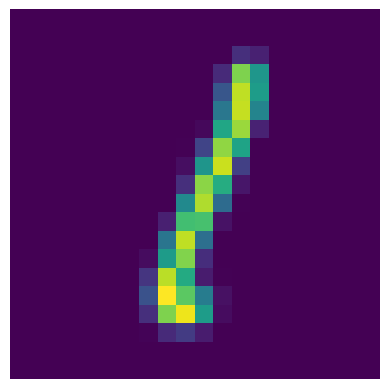

tensor(1)


In [10]:
imshow(data[0].view(20,20,1)) # here we also reshape the image tensor, bring the color channel to be the third dimension
print(target[0])

# Fully Connected Model

This model is defined by us consist of multiple fully connected layers. Each layer consists of a linear transformation (matrix multiplication) and a non linear operation (here we use relu).

At the end we have the softmax function which turns the classification score into propabilities.

In [11]:
def create_fc_model_v1(device):
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=400, out_features=200),
      nn.ReLU(), #non linear function
      nn.Linear(in_features=200, out_features=314),
      nn.ReLU(),
      nn.Linear(in_features=314, out_features=146),
      nn.ReLU(),
      nn.Linear(in_features=146, out_features=400),
      nn.ReLU(),
      nn.Linear(in_features=400, out_features=10), 
      nn.Softmax()
  )

  model = model.to(device) # to load the model to GPU or CPU
  return model


Here I also create the second model that uses DropOut (see you read the abstract of this [paper](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)) to understand what it is.

But generally, it drop some of the neurons so these dropped neurons' values are just 0. They don't contribute to the prediction.

DropOut is demonstrateed to help boosting the predictive/generalization power of the model by preventing the model from overfitting (where training accuracy is higher than validation accuracy). 

We can try both create_fc_model_v1 and create_fc_model_v2 to see whether dropout can help the model. We also may want to experiment with different dropout rate 0.2, 0.3, ect. Because as I experimented, for different problem, and different architecture, we may need a different dropout rate. 

In [12]:
def create_fc_model_v2(device, p=0.2):
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=400, out_features=200),
      nn.Dropout(p),
      nn.ReLU(), #non linear function
      nn.Linear(in_features=200, out_features=314),
      nn.Dropout(p),
      nn.ReLU(),
      nn.Linear(in_features=314, out_features=146),
      nn.Dropout(p),
      nn.ReLU(),
      nn.Linear(in_features=146, out_features=400),
      nn.Dropout(p),
      nn.ReLU(),
      nn.Linear(in_features=400, out_features=10), 
      nn.Softmax()
  )

  model = model.to(device) # to load the model to GPU or CPU
  return model

In [13]:
model = create_fc_model_v1(device) # create a model instance

In [14]:
from torchsummary import summary
summary(model, (1,20,20), 128, device="cuda") # yours would be cuda

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 400]               0
            Linear-2                 [128, 200]          80,200
              ReLU-3                 [128, 200]               0
            Linear-4                 [128, 314]          63,114
              ReLU-5                 [128, 314]               0
            Linear-6                 [128, 146]          45,990
              ReLU-7                 [128, 146]               0
            Linear-8                 [128, 400]          58,800
              ReLU-9                 [128, 400]               0
           Linear-10                  [128, 10]           4,010
          Softmax-11                  [128, 10]               0
Total params: 252,114
Trainable params: 252,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Optimizer

A useful video about stochastic gradient descent: https://www.youtube.com/watch?v=vMh0zPT0tLI

There are different types of optimizers. I think its important to choose a proper optimizer and proper learning rate (I feel this is a hard step for me). We want to choose a proper optimizer and learning rate defining how the model weights' are updated, such that the model can finally converge to the lowest loss in a reasonable number of training epochs.

We can use an SGD optimizer with a constant learning rate. However, adaptive learning rate is prefered. Adaptive learning rate means that the lr can change (often decreased, such as exponentially/linearly decayed as we train more epochs). 


Thus, with using SGD we can add a scheduler defining how we decay the learning rate after a preconfigured number of training epochs.

Another option is that we can use adaptive optimizer, such as Adam, SGD with momentum, so on, that can adapt the learning rate for us without defining a scheduler (You can read about Adam in this https://optimization.cbe.cornell.edu/index.php?title=Adam)

With Adam, we can also define learning rate (as SGD) as the initial learning rate. But here I just use the default learning rate

In [15]:
from torch.optim import SGD, Adam

# optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9) # stochastic gradent descent
optimizer = Adam(model.parameters())

Since our problem is classifification problem with multiple labels, we use Cross Entropy Loss to measure the loss of the model

In [16]:
# loss function
criterion = nn.CrossEntropyLoss()

# Load and Save models

These functions is helpful, you can use it to save the best state of the model. Since training a model may take time, you would not want to retrain the model again, so its always good create functions like these to save the model and reload the model to continue training or to make prediction 


Not only save the model, but we can also save the history list

In [17]:
def save_checkpoint(model:nn.Sequential, history, path: str='dir/file.pt'):
  obj = {}

  obj['model'] = model
  obj['model_state_dict'] = model.state_dict()
  obj['history'] = history

  torch.save(obj, path)

def load_checkpoint(path, device):
  obj = torch.load(path, map_location=device)
  model = obj['model']
  model.load_state_dict(obj['model_state_dict'])
  history = obj['history']

  return model, history

In [18]:
drive.mount('drive') # mount to the google drive so that you can save persistently in your drive
PROJECT_PATH = './drive/MyDrive/Colab Notebooks'

Mounted at drive


# Plot functions

We are going to define a `train` function. In that function, we keep track a list of (train accuracy rate, validation accuracy rate, train loss, and validation loss) for each training epoch and save them in a variable `history`. 


We then use the plot functions defined below with the `history` to see how our model progresses as we train over more number of epochs. 

* was the loss decreasing, or did it decreased and then increased (means that you may have overtrain the model or we may did not tune the learning rate right)?

* Did the loss reach a plaetau, if not, we may need to train more?

* Does the training loss line is lower that the validation loss? If this happens, our model suffers from overfitting (perform well on the training dataset, and perform worse in the validation dataset)

* DOes the validation loss line is lower than the training loss? If this occurs, our model may be underfit.



In [19]:
def plot_train_loss_and_val_loss(history):
  df = pd.DataFrame(history, columns=['train loss', 'train acc', 'val loss', 'val acc'])
  plt.plot(df['train loss'], label='train loss')
  plt.plot(df['val loss'], label='validation loss')
  plt.title('Training loss and validation loss')
  plt.show()

def plot_train_acc_and_val_acc(history):  
  df = pd.DataFrame(history, columns=['train loss', 'train acc', 'val loss', 'val acc'])
  plt.plot(df['train acc'], label='train accuracy')
  plt.plot(df['val acc'], label='validation accuracy')
  plt.title('Training accuracy and validation accuracy')
  plt.show()

# Training function

A few notes for this train function
 * The train function receive an `epochs` argument defining the max number of epochs that it would run.

 * At each epoch, we iterate over each batch inside the `train_loader` to get the images and associated labels. Then we use them to make predictions, compute the loss, the gradient, and update the model weights with an optimizer (See the code inside the for loop `for batch in train_loader`)

 * At each epoch, we also track the train running loss and train running accuracy and after finished training, we compute average train loss and train accuracy rate.

 * After an epoch, we also test the model on the val_loader, compute val loss and val accuracy.

 * Then append train loss, train acc, val loss, val acc to the history list.

 * Once we finish training we also return the history.

 * Lastly, we are using `early stopping`. If the model does not improve (the validation loss is not lower than the lowest validation loss that we have seen so far for a number of `max_epochs_no_improve`, we stop training though we may have not fully train for `epochs` number of epochs

 * We also save the best model using `save_checkpoint` function that we defined above.

In [20]:
def train(model, train_loader, optimizer, criterion, val_loader, epochs, model_path, max_epochs_no_improve=3):
  history = [] 

  lowest_val_loss = float('inf')
  best_accuracy = 0
  no_improve_epochs = 0

  try:
    print(f"Has been trained for {model.epochs}")
    start_epochs = model.epochs + 1
  except:
    print(f"Start training from scratch.")
    model.epochs = 0
    start_epochs = 0

  for e in range(start_epochs, epochs): # a training step
    model.train()

    train_running_loss = 0
    train_running_acc = 0
    train_size = 0
    val_running_loss = 0
    val_running_acc = 0
    val_size =0 
    for batch in train_loader: # iterate over each batch of size 128
      x, y = batch # x: images in tensors, y: labels for images
      x = x.to(device)
      y = y.to(device) 

      # clear the gradient (gradient = multiple derivatives - each is the derivative of the loss with respect to the weight in the model)
      optimizer.zero_grad()

      ## train ##
      probs = model(x)
      loss = criterion(probs, y) # compute the loss of the model at the current state

      loss.backward() # give the optimizer the gradients to update the weights
      
      optimizer.step()

      # log things
      train_running_loss += loss.item()*x.size(0)
      
      _, preds = probs.max(1)
      correct_preds = (y==preds).sum()
      train_running_acc += correct_preds

      train_size += x.size(0)


    else:
      model.eval()

      with torch.no_grad():
          for batch in val_loader: # iterate over each batch of size 128
            x, y = batch # x: images in tensors, y: labels for images
            x = x.to(device)
            y = y.to(device) 

            probs = model(x)
            loss = criterion(probs, y)
            val_running_loss += loss.item()*x.size(0)

            _, preds = probs.max(1)
            correct_preds = (y==preds).sum()
            val_running_acc += correct_preds

            val_size += x.size(0)

    model.epochs += 1

    # compute loss rate and accuracy rate for plotting
    train_acc = train_running_acc/train_size
    train_loss = train_running_loss/train_size
    val_acc = val_running_acc/val_size
    val_loss = val_running_loss/val_size
    history.append((train_loss, train_acc, val_loss, val_acc))

    #check if out loss is reduced
    if val_loss<lowest_val_loss:
      no_improve_epochs = 0
      lowest_val_loss = val_loss
      best_accuracy = val_acc

      save_checkpoint(model, history, model_path)
    else:
      no_improve_epochs +=1

    # early stopping
    if no_improve_epochs == max_epochs_no_improve:
      print(f'Early stopping, best validation accuracy = {val_acc*100:.2f}')
      return history

    # print
    print(f"Finish epoch {e}, training loss={train_loss:.2f}, training acc={train_acc*100:.2f}")
    print(f"\tValidation loss={val_loss:.2f}, validation acc={val_acc*100:.2f}")
  return history



# Create a model and train

Model with augmentation and no dropout

In [21]:
model = create_fc_model_v1(device) # create a model instance
optimizer = Adam(model.parameters()) 
criterion = nn.CrossEntropyLoss()

history = train(model, train_loader, optimizer, criterion, test_loader, 50, PROJECT_PATH + '/fcc_nodropout.pt', 10)

Start training from scratch.
Finish epoch 0, training loss=1.88, training acc=58.99
	Validation loss=1.71, validation acc=74.74
Finish epoch 1, training loss=1.74, training acc=72.48
	Validation loss=1.61, validation acc=84.64
Finish epoch 2, training loss=1.68, training acc=78.61
	Validation loss=1.60, validation acc=86.35
Finish epoch 3, training loss=1.66, training acc=80.06
	Validation loss=1.60, validation acc=86.29
Finish epoch 4, training loss=1.65, training acc=81.15
	Validation loss=1.60, validation acc=85.66
Finish epoch 5, training loss=1.64, training acc=82.02
	Validation loss=1.60, validation acc=86.10
Finish epoch 6, training loss=1.64, training acc=82.55
	Validation loss=1.57, validation acc=89.35
Finish epoch 7, training loss=1.58, training acc=87.80
	Validation loss=1.52, validation acc=94.35
Finish epoch 8, training loss=1.56, training acc=89.76
	Validation loss=1.51, validation acc=95.33
Finish epoch 9, training loss=1.56, training acc=89.75
	Validation loss=1.51, va

You can also uncomment this and try the second model that uses dropout. Maybe try with different dropout rate p as well

In [22]:

model2 = create_fc_model_v2(device, p=0.2) # create a model instance
optimizer = Adam(model2.parameters()) 
criterion = nn.CrossEntropyLoss()

history = train(model2, train_loader, optimizer, criterion, val_loader, 50, PROJECT_PATH + '/fcc_dropout_02.pt')

Start training from scratch.
Finish epoch 0, training loss=1.89, training acc=57.11
	Validation loss=1.76, validation acc=69.82
Finish epoch 1, training loss=1.72, training acc=74.00
	Validation loss=1.63, validation acc=83.04
Finish epoch 2, training loss=1.64, training acc=82.40
	Validation loss=1.58, validation acc=87.88
Finish epoch 3, training loss=1.61, training acc=85.45
	Validation loss=1.58, validation acc=88.50
Finish epoch 4, training loss=1.60, training acc=86.11
	Validation loss=1.56, validation acc=89.64
Finish epoch 5, training loss=1.59, training acc=87.15
	Validation loss=1.55, validation acc=90.98
Finish epoch 6, training loss=1.58, training acc=87.93
	Validation loss=1.55, validation acc=91.16
Finish epoch 7, training loss=1.58, training acc=88.14
	Validation loss=1.55, validation acc=91.35
Finish epoch 8, training loss=1.58, training acc=88.38
	Validation loss=1.55, validation acc=91.01
Finish epoch 9, training loss=1.57, training acc=88.60
	Validation loss=1.54, va

# Visualize and performance

In [23]:
# load the model and the history
model, history = load_checkpoint(PROJECT_PATH + '/fcc_nodropout.pt', device)

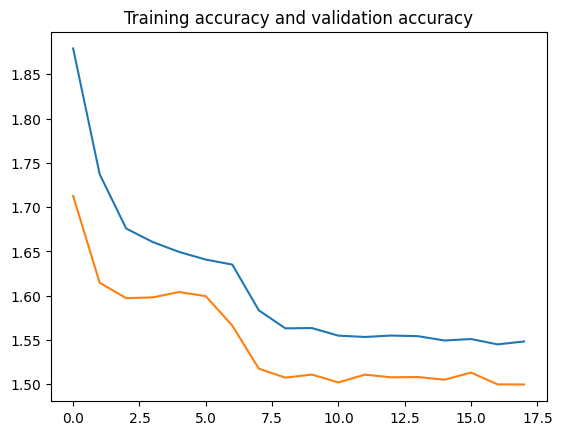

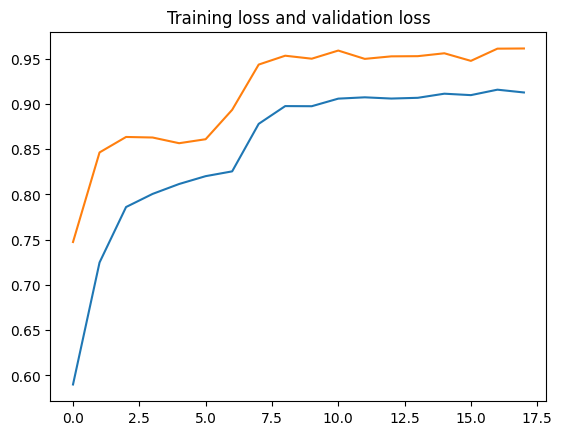

In [24]:
# plot 
plot_train_acc_and_val_acc(history)
plot_train_loss_and_val_loss(history)

# Prediction on the real data


You can create you own image and uses the following function to open the image, and use the model that you just trained to make prediction.

Note that since the MNIST dataset that we used for training contains white digit on the black background. So your image input to the model should be similar, otherwise, the model just not work right (I used powerpoint to create one). 

If you look to the left of the notebook, you will see a little folder icon. You click on that and you will see a sample_data folder. You can put the images that you want to predict inside that folder

In [25]:
def predict(image_loc, model):
  img = Image.open(image_loc)
  print('Image: ')
  img.show()

  img = transformer(img)
  img = img.to(device)

  with torch.no_grad():
    model.eval()
    props = np.round(model(img).cpu()*100, 2)
  print('Predicted probabilities: ', props)

  _, pred = props.max(1)
  print('Predicted Label: ', pred.item())

Image: 


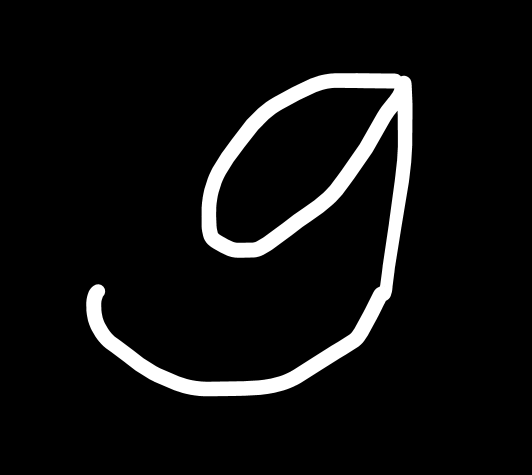

Predicted probabilities:  tensor([[  0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.]])
Predicted Label:  3


In [28]:
# load the model
model, history = load_checkpoint(PROJECT_PATH + '/fcc_nodropout.pt', device)

# make prediction
predict('./sample_data/9_white.png', model)
